In [47]:
import torch.nn as nn

class Policy(nn.Module):
  def __init__(self,input_shape,action_shape):
    super().__init__()
    print("input_shape",input_shape)
    print("action_shape",action_shape)
    self.model = nn.Sequential(
        nn.Linear(input_shape[0],64),
        nn.ReLU(),
        nn.Linear(64,32),
        nn.ReLU(),
        nn.Linear(32,action_shape),
        nn.Softmax(dim = 1)
    )
  def forward(self,x):
    return self.model(x)    

In [83]:
from pymoo.core.algorithm import Algorithm
from pymoo.operators.sampling.rnd import FloatRandomSampling
from torch.distributions import Categorical
from pymoo.core.initialization import Initialization
from pymoo.core.population import Population
from pymoo.core.repair import NoRepair
from torch import optim
import torch
import numpy as np
import gym
from gym import spaces

class MonteCarloGradientPolicyAlgorithm(Algorithm):
    def __init__(self,
                 gamma=0.99,
                 alpha=0.01,
                 num_rounds=100,
                 sample_size=10,
                 sampling=FloatRandomSampling(),
                 repair=NoRepair(),
                 **kwargs):
        
        """
        Parameters
        ----------
        env : 
            The environment to be used in the algorithm.
        policy : {Policy}
            The policy to be used in the algorithm.
        gamma : float, optional
            The discount factor used in the algorithm. The default is 0.99.
        alpha : float, optional
            The learning rate used in the algorithm. The default is 0.01.
        num_episodes : int, optional
            The number of episodes to be run in the algorithm. The default is 100.
        sample_size : int, optional
            The number of samples to be generated from the problems and used in the acquisition function. 
            The default is 10.
        sampling : {Sampling}, optional
            The sampling method used to generate the initial samples. The default is FloatRandomSampling().
        """
         
        super().__init__(**kwargs)

        self.gamma = gamma
        self.alpha = alpha
        self.num_rounds = num_rounds
        self.sample_size = sample_size
        self.sampling = sampling
        self.repair = repair
        
        self.initialization = Initialization(sampling)
        self.is_constraint_model = False
        self.optimizer = None
        self.observation_space = None
        self.action_space = None
        self.data_set_X = None
        self.model = None
        self.states = []
        self.actions = []
        self.probs = []
        self.rewards = []
        self.steps_taken = []

    def _setup(self, problem, **kwargs):
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf,shape=(1,))
        self.action_space = spaces.Box(low=0, high=1, shape=(1,self.problem.n_var))
        self.is_constraint_model = False
        self.model = Policy(np.array([self.problem.n_var]), self.action_space.shape[1])
        self.optimizer = optim.Adam(self.model.parameters(), lr = 1e-2)
        
    def _initialize_infill(self):
        return self.initialization.do(self.problem, 1, algorithm=self)

    def _initialize_advance(self, infills=None, **kwargs):
        self.data_set_X = self.pop.get("X")
        #super()._initialize_advance(infills=infills, **kwargs)

    def _infill(self):
        state = self.sampling.do(self.problem, 1, algorithm=self).get("X")[0]
        steps = 0
        ep_rewards = 0
        batch_rewards = []
        log_probs = []
        
        while steps < self.num_rounds:
            a, log_p = self.action(self.model, torch.Tensor(state).unsqueeze(0))
            log_probs.append(log_p)
            new_state, reward = self.step(a,state)
            batch_rewards.append(reward)
            ep_rewards += reward
            steps +=1  
            state = new_state
      
        
        self.rewards.append(ep_rewards)
        self.steps_taken.append(steps)
        print("Episode: {} --- Rewards: {} --- Steps: {}".format(self.n_iter, ep_rewards, steps))
        self.update_policy(self.n_iter, self.model, self.optimizer, batch_rewards, log_probs)

        self.data_set_X = np.vstack((self.data_set_X, state))
        off = Population.new(X=self.data_set_X)
        self.pop = off
        self.repair(self.problem, off)
        return off
        
    def _advance(self, infills=None, **kwargs):
        return super()._advance(infills=infills, **kwargs)
    
    
    def _finalize(self):
        return super()._finalize()
    
    def action(self, model, s):
        # simple pytorch aproach for action-selection and log-prob calc 
        #https://pytorch.org/docs/stable/distributions.html
        prob = model(s)
        m = Categorical(prob)
        a = m.sample()
        # log p(a∣π(s))
        log_p = m.log_prob(a)
        #print(a.item(), log_p)
        return a.item(), log_p
    
    def step(self, action: np.ndarray, state):
        current_X = state
        X_new = current_X + action
        print("current_X", current_X)
        print("action", action)
        print("X_new", X_new)
        evlaution_of_new_points = self.problem.evaluate(np.array(X_new))
        #if self.is_constraint_model or self.problem.n_eq_constr > 0:
        #    Y_new = evlaution_of_new_points[0]
        #    Constraint_new = evlaution_of_new_points[1]
        #else:
        Y_new = evlaution_of_new_points[0]
        xl, xu = self.problem.bounds()
        if np.any(X_new < xl) or np.any(X_new > xu):
            rewards = -X_new**2
        reward = -Y_new

        state = np.array(X_new)

        return state, reward
    
    def update_policy(self, ep, model, optimizer,batch_rewards,log_probs):
        R = 0
        gamma = 0.99
        policy_loss = []
        rewards = []
        #calc discounted Rewards
        for r in batch_rewards[::-1]: # reverses the list of rewards 
            R = r + gamma * R
            rewards.insert(0, R) # inserts the current rewart to first position
            
        rewards = torch.tensor(rewards)
        # standardization to get data of zero mean and varianz 1, stabilizes learning 
        #-- attention scaling rewards looses information of special events with higher rewards - addapting on different environments  
        rewards = (rewards - rewards.mean()) / (rewards.std() + ep)
        for log_prob, reward in zip(log_probs, rewards):
            policy_loss.append(-log_prob * reward) #baseline+
        
        optimizer.zero_grad()
        policy_loss = torch.cat(policy_loss).sum()
        policy_loss.backward()
        optimizer.step()
        """G = 0
        for t in reversed(range(len(states))):
            G = self.gamma * G + rewards[t]
            state = states[t]
            action = actions[t]
            grad_log_prob = self.policy.grad_log_prob(state, action)
            self.policy.theta += self.alpha * G * grad_log_prob"""

    """def run_episode(self):
        states = []
        actions = []
        rewards = []
        state = self.env.reset()
        done = False
        while not done:
            action = self.policy.sample_action(state)
            next_state, reward, done, _ = self.env.step(action)
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            state = next_state
        return states, actions, rewards"""
    
    

input_shape [2]
action_shape 2
current_X [-32.76050433 -12.95433252]
action 0
X_new [-32.76050433 -12.95433252]
current_X [-32.76050433 -12.95433252]
action 0
X_new [-32.76050433 -12.95433252]
current_X [-32.76050433 -12.95433252]
action 0
X_new [-32.76050433 -12.95433252]
current_X [-32.76050433 -12.95433252]
action 0
X_new [-32.76050433 -12.95433252]
current_X [-32.76050433 -12.95433252]
action 0
X_new [-32.76050433 -12.95433252]
current_X [-32.76050433 -12.95433252]
action 0
X_new [-32.76050433 -12.95433252]
current_X [-32.76050433 -12.95433252]
action 0
X_new [-32.76050433 -12.95433252]
current_X [-32.76050433 -12.95433252]
action 0
X_new [-32.76050433 -12.95433252]
current_X [-32.76050433 -12.95433252]
action 0
X_new [-32.76050433 -12.95433252]
current_X [-32.76050433 -12.95433252]
action 0
X_new [-32.76050433 -12.95433252]
current_X [-32.76050433 -12.95433252]
action 0
X_new [-32.76050433 -12.95433252]
current_X [-32.76050433 -12.95433252]
action 0
X_new [-32.76050433 -12.9543325

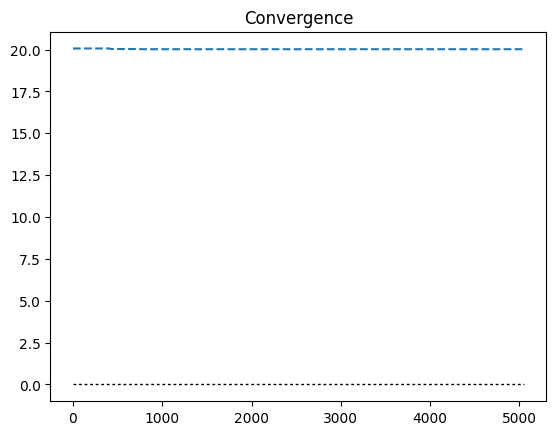

In [85]:
from pymoo.problems import get_problem
from pymoo.optimize import minimize
from pymoo.indicators.gd import GD
from pymoo.indicators.igd import IGD
import matplotlib.pyplot as plt
import numpy as np
from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.termination import get_termination
from random import randint
from pymoo.constraints.as_obj import ConstraintsAsObjective
from pymoo.termination.ftol import SingleObjectiveSpaceTermination
from pymoo.termination.robust import RobustTermination
from pymoo.termination.default import DefaultMultiObjectiveTermination

problem = get_problem("ackley", n_var=2, a=20, b=1/5, c=2 * np.pi)
algorithm3 = MonteCarloGradientPolicyAlgorithm()
res = minimize( problem,
                algorithm3,
                save_history=True,
                termination=('n_iter', 100),
                seed = 1,
                return_least_infeasible=True,
                verbose=True)

pf = problem.pareto_front()
print("PF",pf[0])
ind = GD(pf)
print("GD", ind(res.F))
ind2 = IGD(pf)
print("IGD", ind2(res.F))


n_evals = np.array([e.evaluator.n_eval for e in res.history])
opt = np.array([e.opt[0].F for e in res.history])
print(opt)
plt.title("Convergence")
plt.plot(n_evals, opt, "--")
plt.plot(n_evals, np.repeat(pf[0],len(n_evals)), 'k-', lw=1,dashes=[2, 2])
#plt.yscale("log")
plt.show()